### Import plugins

In [2]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import os
import math
#import imageio
from scipy.ndimage.interpolation import map_coordinates
from pprint import pprint
import glob
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator
from copy import copy
from copy import deepcopy
#from mpl_toolkits.axes_grid1 import make
#_axes_locatable
%matplotlib inline
from scipy import stats
import multiprocessing as mp
import matplotlib.patches as patches

In [3]:
_wbgyr_cdict = {'red': ((0.0,  255./255, 255./255),
                        (0.125, 173./255, 173./255),
                        (0.25,  95./255,  95./255),
                        (0.375, 73./255,  73./255),
                        (0.5,  165./255, 164./255),
                        (0.625, 248./255, 248./255),
                        (0.75, 236./255, 236./255),
                        (0.875, 200./255, 200./255),
                        (1.0,  146./255, 146./255)),
                'green': ((0.0,  255./255, 255./255),
                          (0.125, 224./255, 224./255),
                          (0.25, 163./255, 163./255),
                          (0.375, 166./255, 166./255),
                          (0.5,  207./255, 207./255),
                          (0.625, 184./255, 184./255),
                          (0.75,  86./255,  86./255),
                          (0.875, 29./255,  29./255),
                          (1.0,   21./255,  21./255)),
                'blue': ((0.0,  255./255, 255./255),
                         (0.125, 248./255, 248./255),
                         (0.25, 214./255, 214./255),
                         (0.375, 120./255, 120./255),
                         (0.5,   81./255,  81./255),
                         (0.625, 73./255,  73./255),
                         (0.75,  41./255,  41./255),
                         (0.875, 38./255,  38./255),
                         (1.0,   25./255,  25./255))}
# And reverse
_wbgyr_cdict_r = deepcopy(_wbgyr_cdict)
for i in _wbgyr_cdict_r.keys():
    _wbgyr_cdict_r[i] = [(1-j[0], j[1], j[2]) for j in _wbgyr_cdict_r[i]]
    _wbgyr_cdict_r[i].reverse()

cmap = LinearSegmentedColormap('WBGYR', _wbgyr_cdict)
cmap.set_bad('#D2D2D2')
plt.register_cmap(cmap=cmap)

cmap_r = LinearSegmentedColormap('WBGYR', _wbgyr_cdict_r)
cmap_r.set_bad('#D2D2D2')
plt.register_cmap(cmap=cmap_r)

/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  if __name__ == '__main__':


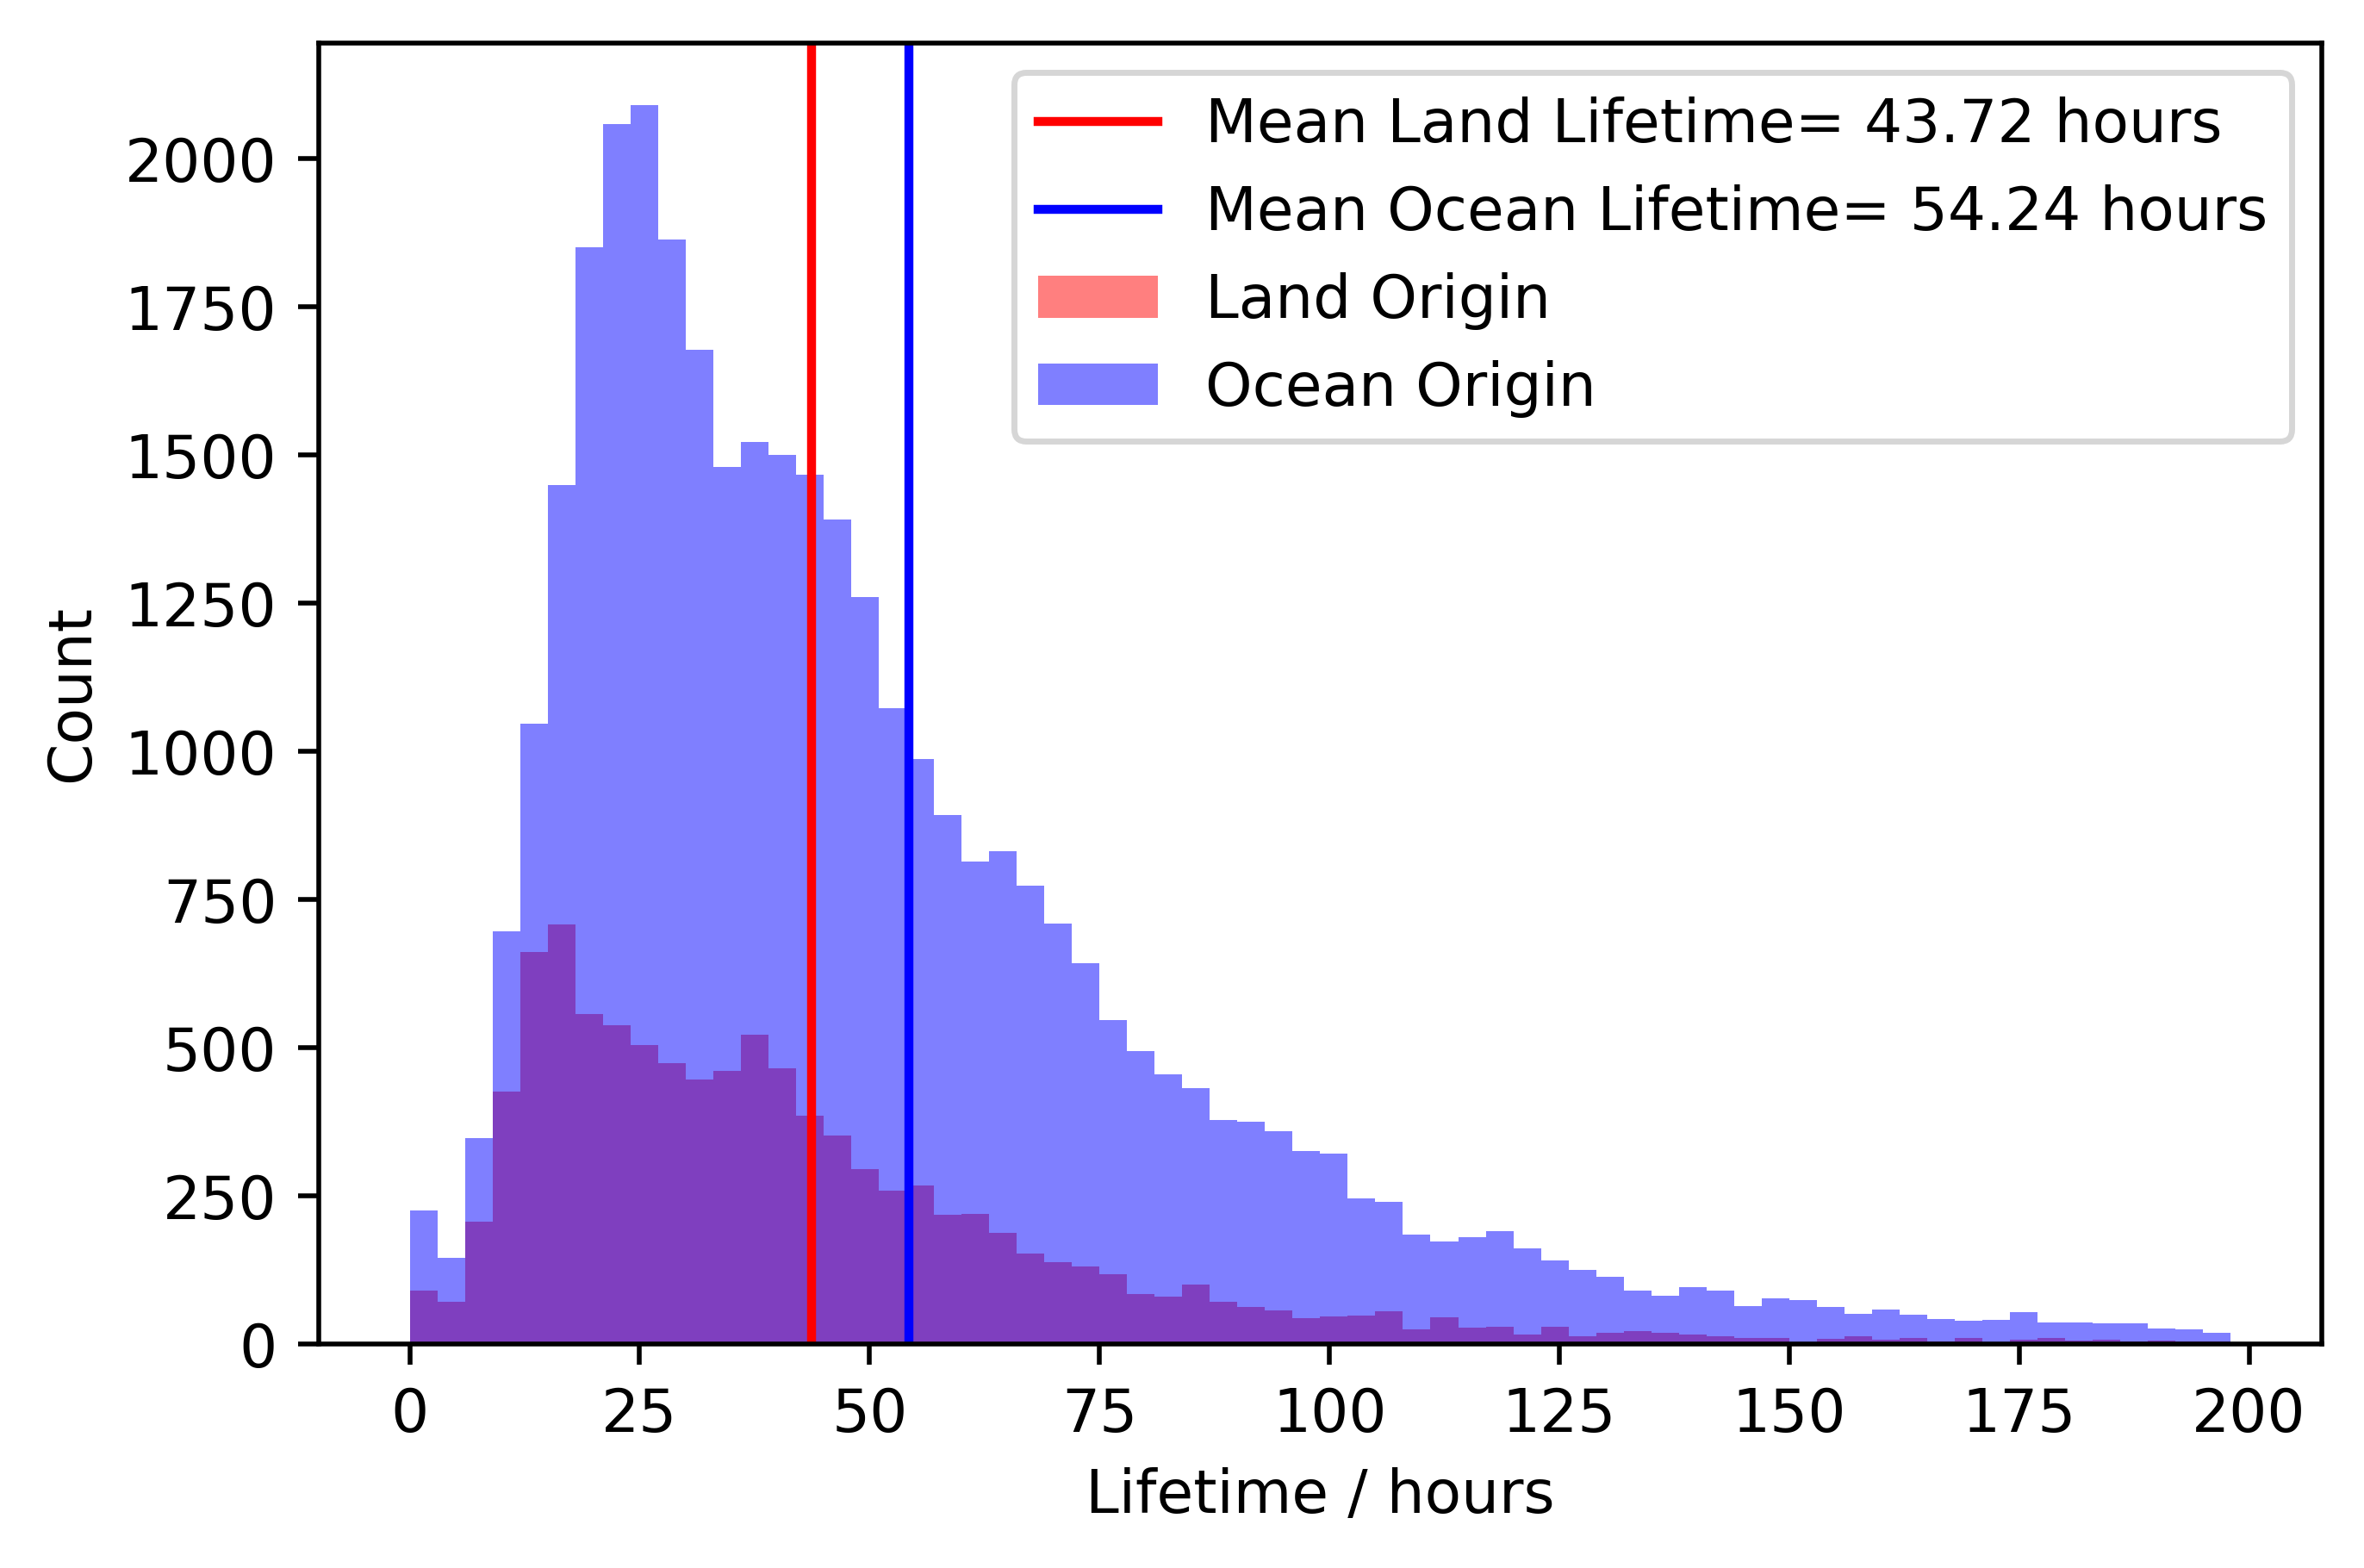

In [127]:
plt.figure(dpi=500)
plt.hist(landlifetime.flatten(),bins=np.arange(0,200,3),alpha=0.5,color='red',label='Land Origin')
plt.axvline(np.nanmean(landlifetime[1:]),color='red',label='Mean Land Lifetime= ' + str(np.round(np.nanmean(landlifetime[1:]),2))+ ' hours')
plt.hist(oceanlifetime.flatten(),bins=np.arange(0,200,3),alpha=0.5,color='blue', label='Ocean Origin')
plt.axvline(np.nanmean(oceanlifetime[1:]),color='blue',label='Mean Ocean Lifetime= ' + str(np.round(np.nanmean(oceanlifetime[1:]),2))+ ' hours')
plt.xlabel('Lifetime / hours')
plt.ylabel('Count')
plt.legend()
plt.savefig('CRE_Lifetime_LO.pdf',dpi=700,tight_layout=True)


### Create the avg CREs

In [4]:
import warnings
print('is it doing?')

yedges_net = np.arange(-650,650,1)
yedges_lw = np.arange(-500,0,1)
yedges_sw = np.arange(-100,900,1)
yedges_solar = np.arange(0,1400,5)
xedges = np.arange(0,500,1)

cereshour = 8760
k=0
year = 2008

tsc = xr.open_mfdataset('/net/seldon/disk2/Users/gah20/TSCISCCP/TSC_convolve/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['TSC'][:,2:62]
landocean = xr.open_mfdataset('/net/seldon/disk2/Users/gah20/TSCISCCP/TSC_convolve/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvOrigin'][:,2:62]
aodtsc = xr.open_mfdataset('/net/seldon/disk2/Users/gah20/TSCISCCP/TSC_convolve/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvAOD'][:,2:62]
detinsit = xr.open_mfdataset('/net/seldon/disk2/Users/gah20/TSCISCCP/TSC_CURRENT/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvCir'][:,2:62]

isccp = xr.open_mfdataset('/net/seldon/disk2/Users/gah20/ISCCP/access/isccp-basic/hgg/'+str(year)+'*/200*.nc',combine='nested',concat_dim='time')
taupc = isccp['n_pctaudist']
levtau = isccp['levtau']
levpc = isccp['levpc']
tauraw = isccp['tau']
pcraw = isccp['pc']
isccptime = isccp['time']

ds_w = xr.open_mfdataset('/net/seldon/disk1/Data/CERES/SYN1deg-Hour-Ed4/'+str(year)+'/CERES_SYN1deg-1H_Terra-Aqua-MODIS_Ed4.1_Total_*.nc',combine = 'by_coords', concat_dim="time")
swall = ds_w['toa_sw_all_1h'][:]
swclr = ds_w['toa_sw_clr_1h'][:]
lwall = ds_w['toa_lw_all_1h'][:]
lwclr = ds_w['toa_lw_clr_1h'][:]
netall = ds_w['toa_net_all_1h'][:]
netclr = ds_w['toa_net_clr_1h'][:]
solar = ds_w['toa_solar_all_1h'][:]
timeceres = ds_w['time'][:]
cf = ds_w['cldarea_total_1h'][:]

offset = np.argmin(np.abs(isccp['time'][:].values - ds_w['time'][0].values))

meanlw = np.nanmean(lwclr[:],axis=0)
levels = 3
lowcloudraw = np.nansum(np.nansum(isccp['n_pctaudist'][offset:,:,levels:,60:120],axis=1),axis=1)
lowcloud_day = np.where(lowcloudraw<0,np.nan,lowcloudraw)
lowcloud_night = np.where(np.nansum(isccp['n_pcdist'][offset:,levels:,60:120],axis=1)>100,np.nan,np.nansum(isccp['n_pcdist'][offset:,levels:,60:120],axis=1))
lowcloud = np.where(np.isnan(lowcloud_day),lowcloud_night,lowcloud_day)


timeceres[0::3][0:len(isccp['time'][offset:])]


swcldy  = (swall[0::3][0:len(isccp['time'][offset:])] - swclr[0::3][0:len(isccp['time'][offset:])])
netcldy = (netall[0::3][0:len(isccp['time'][offset:])] - netclr[0::3][0:len(isccp['time'][offset:])])

lwclr_f = np.where(np.isnan(lwclr[0::3][0:len(isccp['time'][offset:])]),meanlw,lwclr[0::3][0:len(isccp['time'][offset:])])
lwcldy = (lwall[0::3][0:len(isccp['time'][offset:])] - lwclr_f) 
solar_t = solar[0::3][0:len(isccp['time'][offset:])]
swcldy_dayf = np.where((lowcloud_day<1),swcldy,np.nan)
lwcldy_dayf = np.where((lowcloud_day<1),lwcldy,np.nan)

swcldy_f_nans = np.where((lowcloud<1),swcldy,np.nan)
lwcldy_f = np.where((lowcloud<1),lwcldy,np.nan)
tsc_t = (np.asarray(tsc[offset*3::3]))

tsc_l = np.asarray(np.where(landocean>0,tsc,np.nan))
tsc_o = np.asarray(np.where(landocean<0,tsc,np.nan))

tsc_d = np.asarray(np.where(detinsit>0,tsc,np.nan)[offset*3::3])
tsc_i = np.asarray(np.where(detinsit<0,tsc,np.nan)[offset*3::3])

tsc_d_l = np.asarray(np.where(detinsit>0,tsc_l,np.nan)[offset*3::3])
tsc_i_l = np.asarray(np.where(detinsit<0,tsc_l,np.nan)[offset*3::3])

tsc_d_o = np.asarray(np.where(detinsit>0,tsc_o,np.nan)[offset*3::3])
tsc_i_o = np.asarray(np.where(detinsit<0,tsc_o,np.nan)[offset*3::3])

swcldy_dayf = np.where(solar_t>0,swcldy_dayf,0)
swcldy_f = np.where(solar_t>0,swcldy_f_nans,0)
swcldy_fg = np.where(lowcloud<1,swcldy_f,np.nan)

H_sw_o_det, xedges, yedges_sw = np.histogram2d(tsc_d_o.flatten(),np.asarray(swcldy_fg[0:len(tsc_l)]).flatten(), bins=(xedges,yedges_sw))
H_lw_o_det, xedges, yedges_lw = np.histogram2d(tsc_d_o.flatten(),np.asarray(lwcldy_f[0:len(tsc_l)]).flatten(), bins=(xedges,yedges_lw))

H_sw_o_ins, xedges, yedges_sw = np.histogram2d(tsc_i_o.flatten(),np.asarray(swcldy_fg[0:len(tsc_l)]).flatten(), bins=(xedges,yedges_sw))
H_lw_o_ins, xedges, yedges_lw = np.histogram2d(tsc_i_o.flatten(),np.asarray(lwcldy_f[0:len(tsc_l)]).flatten(), bins=(xedges,yedges_lw))

H_sw_o_all, xedges, yedges_sw = np.histogram2d(tsc_o[offset*3::3].flatten(),np.asarray(swcldy_fg[0:len(tsc_l)]).flatten(), bins=(xedges,yedges_sw))
H_lw_o_all, xedges, yedges_lw = np.histogram2d(tsc_o[offset*3::3].flatten(),np.asarray(lwcldy_f[0:len(tsc_l)]).flatten(), bins=(xedges,yedges_lw))

H_sw_l_det, xedges, yedges_sw = np.histogram2d(tsc_d_l.flatten(),np.asarray(swcldy_fg[0:len(tsc_l)]).flatten(), bins=(xedges,yedges_sw))
H_lw_l_det, xedges, yedges_lw = np.histogram2d(tsc_d_l.flatten(),np.asarray(lwcldy_f[0:len(tsc_l)]).flatten(), bins=(xedges,yedges_lw))

H_sw_l_ins, xedges, yedges_sw = np.histogram2d(tsc_i_l.flatten(),np.asarray(swcldy_fg[0:len(tsc_l)]).flatten(), bins=(xedges,yedges_sw))
H_lw_l_ins, xedges, yedges_lw = np.histogram2d(tsc_i_l.flatten(),np.asarray(lwcldy_f[0:len(tsc_l)]).flatten(), bins=(xedges,yedges_lw))

H_sw_l_all, xedges, yedges_sw = np.histogram2d(tsc_l[offset*3::3].flatten(),np.asarray(swcldy_fg[0:len(tsc_l)]).flatten(), bins=(xedges,yedges_sw))
H_lw_l_all, xedges, yedges_lw = np.histogram2d(tsc_l[offset*3::3].flatten(),np.asarray(lwcldy_f[0:len(tsc_l)]).flatten(), bins=(xedges,yedges_lw))

H_sw_all, xedges, yedges_sw = np.histogram2d(tsc_t.flatten(),np.asarray(swcldy_fg[0:len(tsc_l)]).flatten(), bins=(xedges,yedges_sw))
H_lw_all, xedges, yedges_lw = np.histogram2d(tsc_t.flatten(),np.asarray(lwcldy_f[0:len(tsc_l)]).flatten(), bins=(xedges,yedges_lw)) 

H_sw_det, xedges, yedges_sw = np.histogram2d(tsc_d.flatten(),np.asarray(swcldy_fg[0:len(tsc_l)]).flatten(), bins=(xedges,yedges_sw))
H_lw_det, xedges, yedges_lw = np.histogram2d(tsc_d.flatten(),np.asarray(lwcldy_f[0:len(tsc_l)]).flatten(), bins=(xedges,yedges_lw))

H_sw_ins, xedges, yedges_sw = np.histogram2d(tsc_i.flatten(),np.asarray(swcldy_fg[0:len(tsc_l)]).flatten(), bins=(xedges,yedges_sw))
H_lw_ins, xedges, yedges_lw = np.histogram2d(tsc_i.flatten(),np.asarray(lwcldy_f[0:len(tsc_l)]).flatten(), bins=(xedges,yedges_lw))


is it doing?


/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


In [5]:
H_norm_lw_det_o = np.zeros((499,499))
H_norm_sw_det_o = np.zeros((499,999))
H_norm_lw_ins_o = np.zeros((499,499))
H_norm_sw_ins_o = np.zeros((499,999))
H_norm_lw_all_o = np.zeros((499,499))
H_norm_sw_all_o = np.zeros((499,999))

H_norm_lw_det_l = np.zeros((499,499))
H_norm_sw_det_l = np.zeros((499,999))
H_norm_lw_ins_l = np.zeros((499,499))
H_norm_sw_ins_l = np.zeros((499,999))
H_norm_lw_all_l = np.zeros((499,499))
H_norm_sw_all_l = np.zeros((499,999))

H_norm_lw_det = np.zeros((499,499))
H_norm_sw_det = np.zeros((499,999))
H_norm_lw_ins = np.zeros((499,499))
H_norm_sw_ins = np.zeros((499,999))

H_norm_lw_all = np.zeros((499,499))
H_norm_sw_all = np.zeros((499,999))


for i in range(499):
    H_norm_lw_det_o[i] = H_lw_o_det[i] / np.sum(H_lw_o_det[i])
    H_norm_sw_det_o[i] = H_sw_o_det[i] / np.sum(H_sw_o_det[i])
    H_norm_sw_ins_o[i] = H_sw_o_ins[i] / np.sum(H_sw_o_ins[i])
    H_norm_lw_ins_o[i] = H_lw_o_ins[i] / np.sum(H_lw_o_ins[i])
    H_norm_sw_all_o[i] = H_sw_o_all[i] / np.sum(H_sw_o_all[i])
    H_norm_lw_all_o[i] = H_lw_o_all[i] / np.sum(H_lw_o_all[i])

    H_norm_lw_det_l[i] = H_lw_l_det[i] / np.sum(H_lw_l_det[i])
    H_norm_sw_det_l[i] = H_sw_l_det[i] / np.sum(H_sw_l_det[i])
    H_norm_sw_ins_l[i] = H_sw_l_ins[i] / np.sum(H_sw_l_ins[i])
    H_norm_lw_ins_l[i] = H_lw_l_ins[i] / np.sum(H_lw_l_ins[i])
    H_norm_sw_all_l[i] = H_sw_l_all[i] / np.sum(H_sw_l_all[i])
    H_norm_lw_all_l[i] = H_lw_l_all[i] / np.sum(H_lw_l_all[i])

    H_norm_lw_det[i] = H_lw_det[i] / np.sum(H_lw_det[i])
    H_norm_sw_det[i] = H_sw_det[i] / np.sum(H_sw_det[i])
    H_norm_sw_ins[i] = H_sw_ins[i] / np.sum(H_sw_ins[i])
    H_norm_lw_ins[i] = H_lw_ins[i] / np.sum(H_lw_ins[i])

    H_norm_lw_all[i] = H_lw_all[i] / np.sum(H_lw_all[i])
    H_norm_sw_all[i] = H_sw_all[i] / np.sum(H_sw_all[i])
    

LW_AVERAGE_det_o = np.zeros((499))
SW_AVERAGE_det_o = np.zeros((499))
LW_AVERAGE_det_l = np.zeros((499))
SW_AVERAGE_det_l = np.zeros((499))

LW_AVERAGE_ins_o = np.zeros((499))
SW_AVERAGE_ins_o = np.zeros((499))
LW_AVERAGE_ins_l = np.zeros((499))
SW_AVERAGE_ins_l = np.zeros((499))

LW_AVERAGE_all_o = np.zeros((499))
SW_AVERAGE_all_o = np.zeros((499))
LW_AVERAGE_all_l = np.zeros((499))
SW_AVERAGE_all_l = np.zeros((499))

LW_AVERAGE_det = np.zeros((499))
SW_AVERAGE_det = np.zeros((499))
LW_AVERAGE_ins = np.zeros((499))
SW_AVERAGE_ins = np.zeros((499))

LW_AVERAGE_all = np.zeros((499))
SW_AVERAGE_all = np.zeros((499))

for i in range(499):

    LW_AVERAGE_det_o[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_det_o[i])
    SW_AVERAGE_det_o[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_det_o[i])
    LW_AVERAGE_det_l[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_det_l[i])
    SW_AVERAGE_det_l[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_det_l[i])

    LW_AVERAGE_ins_o[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_ins_o[i])
    SW_AVERAGE_ins_o[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_ins_o[i])
    LW_AVERAGE_ins_l[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_ins_l[i])
    SW_AVERAGE_ins_l[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_ins_l[i])

    LW_AVERAGE_all_o[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_all_o[i])
    SW_AVERAGE_all_o[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_all_o[i])
    LW_AVERAGE_all_l[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_all_l[i])
    SW_AVERAGE_all_l[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_all_l[i])

    LW_AVERAGE_det[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_det[i])
    SW_AVERAGE_det[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_det[i])
    LW_AVERAGE_ins[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_ins[i])
    SW_AVERAGE_ins[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_ins[i])

    LW_AVERAGE_all[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_all[i])
    SW_AVERAGE_all[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_all[i])

/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/

In [74]:
count_i_l = np.where(np.isnan(swcldy_fg),np.nan,tsc_i_l)
count_d_l = np.where(np.isnan(swcldy_fg),np.nan,tsc_d_l)
count_i_o = np.where(np.isnan(swcldy_fg),np.nan,tsc_i_o)
count_d_o = np.where(np.isnan(swcldy_fg),np.nan,tsc_d_o)

tsc_counts_i = np.where(np.isnan(swcldy_fg),np.nan,tsc_i)
tsc_counts_d = np.where(np.isnan(swcldy_fg),np.nan,tsc_d)
tsc_counts = np.where(np.isnan(swcldy_fg),np.nan,tsc_t)

tsc_o_c = np.where(np.isnan(swcldy_fg),np.nan,tsc_o[offset*3::3])
tsc_l_c = np.where(np.isnan(swcldy_fg),np.nan,tsc_l[offset*3::3])

counts_l = np.histogram(np.asarray(tsc_l_c).flatten(),bins=np.arange(0,500,1))[0]
counts_o = np.histogram(np.asarray(tsc_o_c).flatten(),bins=np.arange(0,500,1))[0]

counts = np.histogram(np.asarray(tsc_counts).flatten(),bins=np.arange(0,500,1))[0]
counts_det = np.histogram(np.asarray(tsc_counts_d).flatten(),bins=np.arange(0,500,1))[0]
counts_ins = np.histogram(np.asarray(tsc_counts_i).flatten(),bins=np.arange(0,500,1))[0]



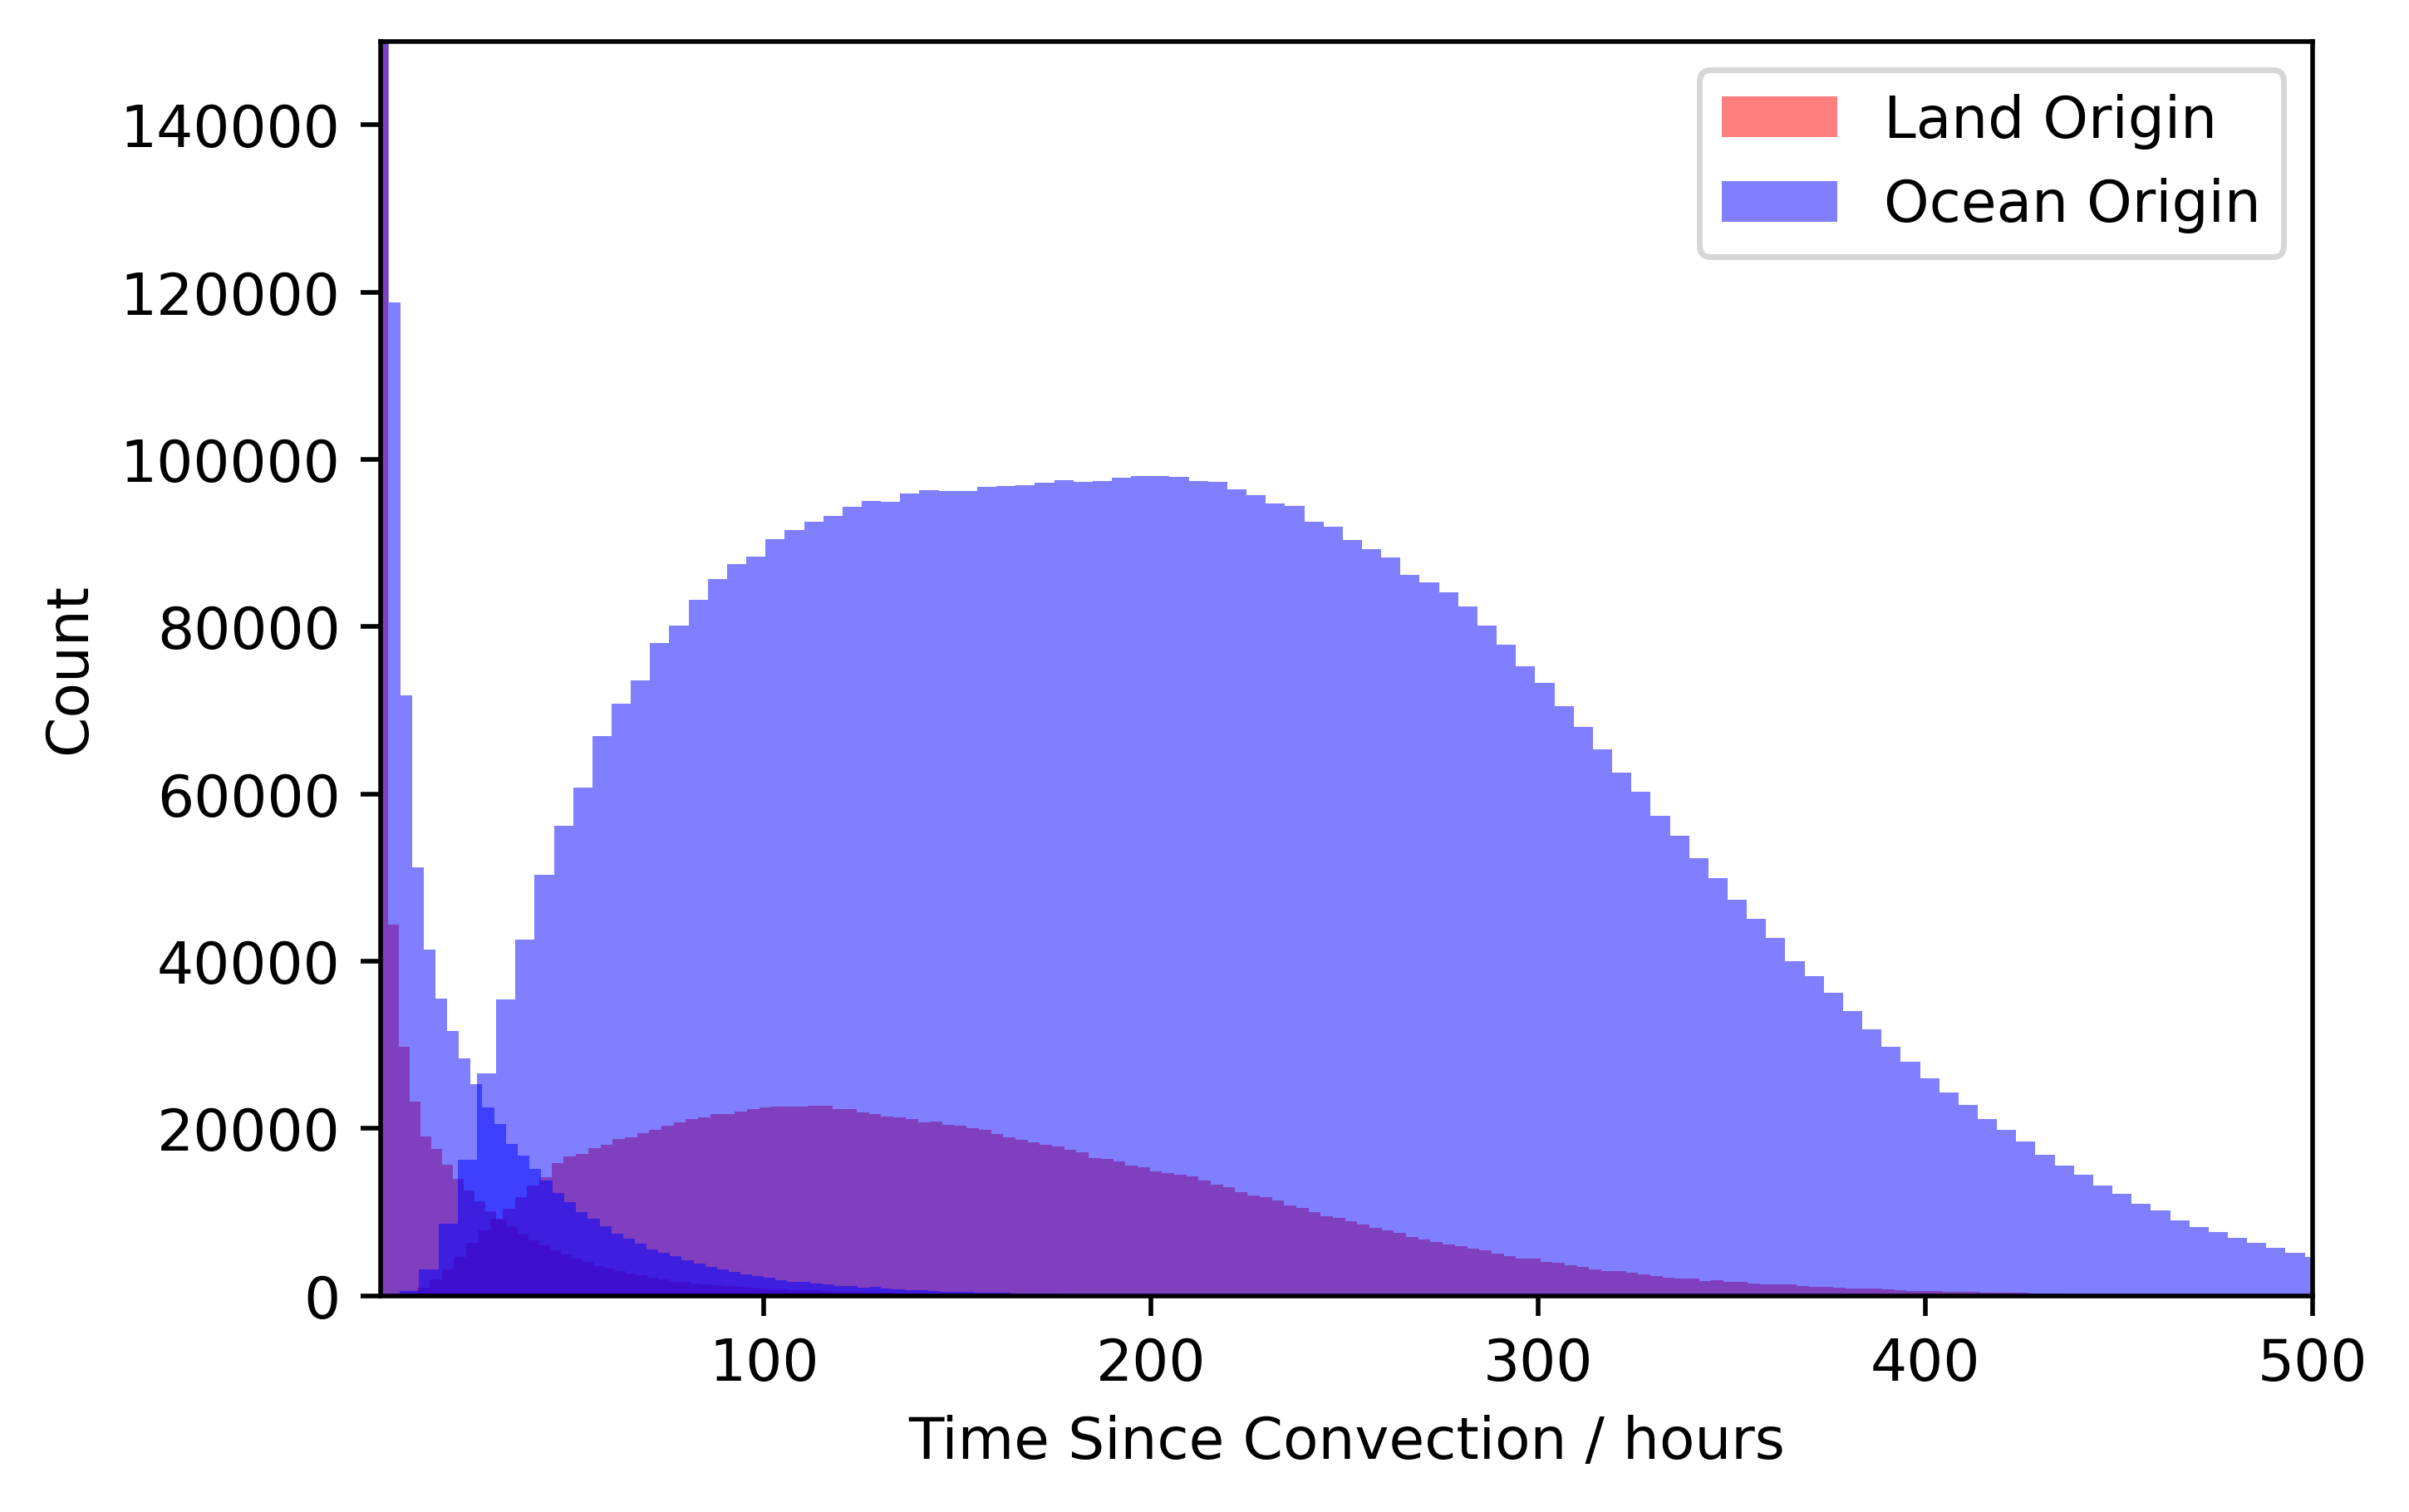

In [11]:
plt.figure(dpi=500)
plt.hist(count_i_l.flatten(),bins=200,alpha=0.5,color='red',label='Land Origin')
plt.hist(count_d_l.flatten(),bins=200,alpha=0.5,color='red')
plt.hist(count_i_o.flatten(),bins=200,alpha=0.5,color='blue',label='Ocean Origin')
plt.hist(count_d_o.flatten(),bins=200,alpha=0.5,color='blue')
plt.xlim(1,500)
plt.ylim(0,150000)
plt.xlabel('Time Since Convection / hours')
plt.ylabel('Count')
plt.legend()
plt.show()

In [1]:
plt.plot(counts_o/counts + counts_l/counts)

NameError: name 'plt' is not defined

In [66]:
totalnetforcing = np.nansum(((weighted_net[:]) * (counts[:])) /np.nansum(counts[:]))



/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


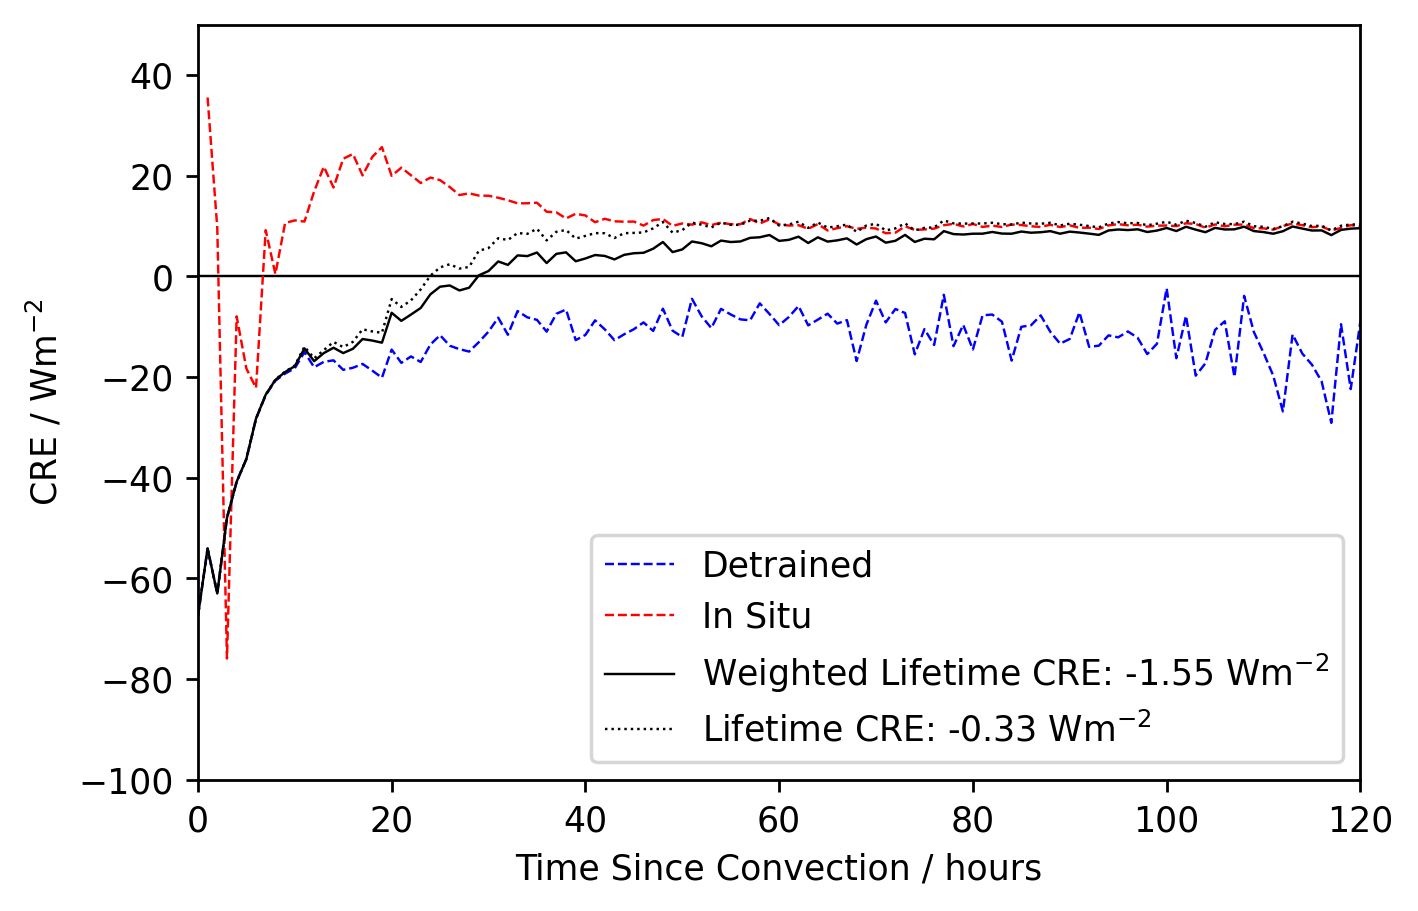

In [71]:
weighted_net = (LW_AVERAGE_det*(counts_det/counts) + SW_AVERAGE_det*(counts_det/counts)) + (LW_AVERAGE_ins*(counts_ins/counts) + SW_AVERAGE_ins*(counts_ins/counts))
weighted_net[0] = LW_AVERAGE_det[0] + SW_AVERAGE_det[0]

plt.figure(dpi=250)
plt.axhline(0,color='k',linewidth=0.7)
plt.plot(LW_AVERAGE_det + SW_AVERAGE_det, label='Detrained',color='blue',linestyle='--',linewidth=0.7)
plt.plot(LW_AVERAGE_ins + SW_AVERAGE_ins, label='In Situ',color='red',linestyle='--',linewidth=0.7)

plt.plot(weighted_net,color='k',linestyle='-',linewidth=0.7,label='Weighted Lifetime CRE: '+str(np.round(totalnetforcing,2))+ ' Wm$^{-2}$')

plt.plot(LW_AVERAGE_all+SW_AVERAGE_all,color='k',linestyle=':',linewidth=0.7,label='Lifetime CRE: ' + str(np.round(np.nansum(((LW_AVERAGE_all+SW_AVERAGE_all) * (counts[:])) /np.nansum(counts[:])),2))+ ' Wm$^{-2}$')
plt.plot()

plt.xlim(0,120)

plt.ylim(-100,50)
plt.legend(ncol=1)
plt.xlabel('Time Since Convection / hours')
plt.ylabel('CRE / Wm$^{-2}$')
plt.savefig('TotalNETFORCING.png',dpi=500,tight_layout=True)

In [ ]:
count_

/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  app.launch_new_instance()


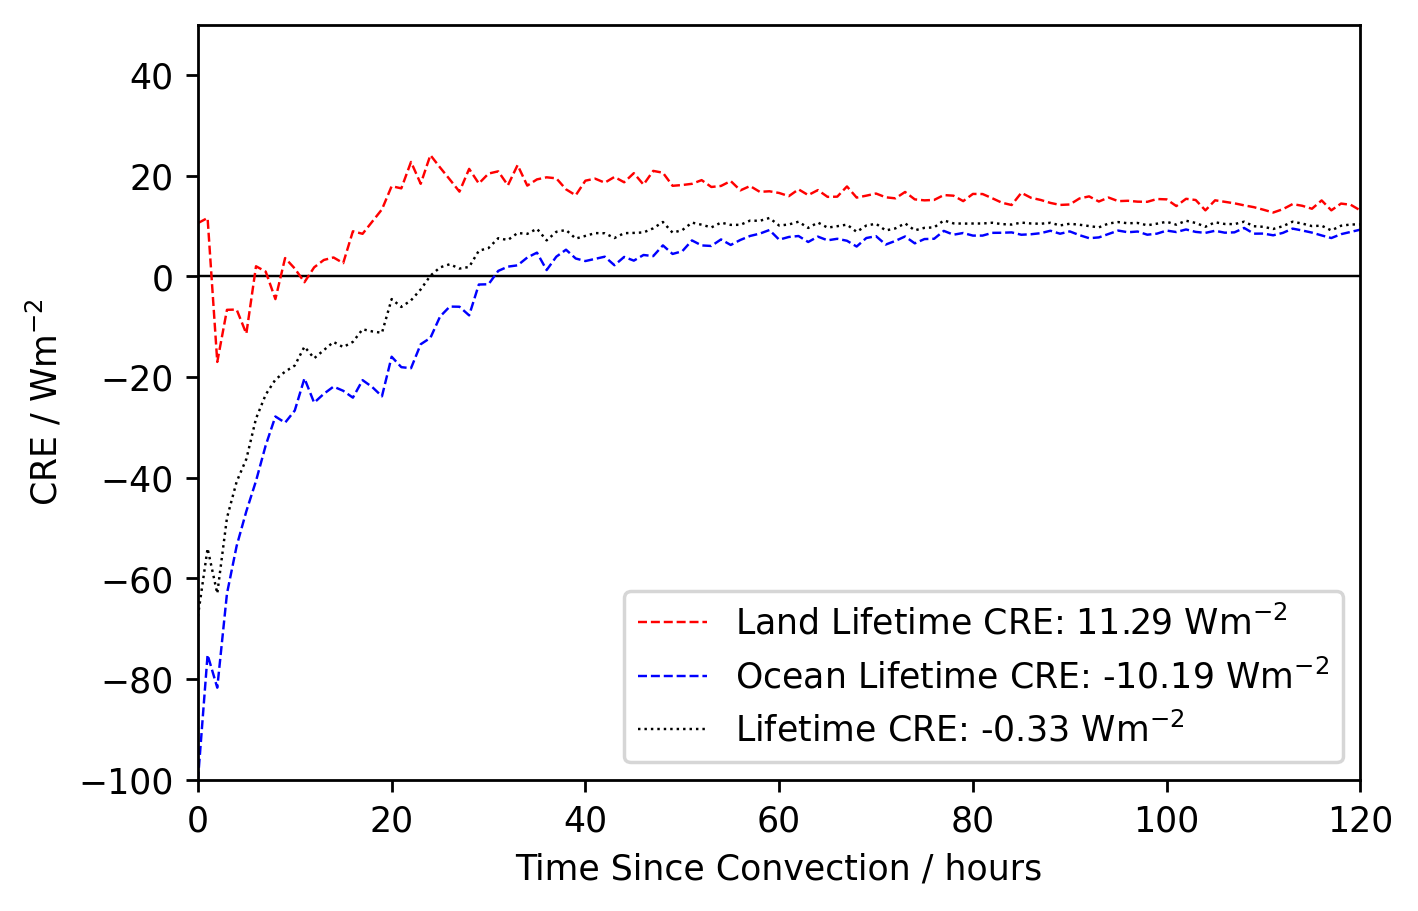

In [82]:
plt.figure(dpi=250)
plt.axhline(0,color='k',linewidth=0.7)
plt.plot(LW_AVERAGE_all_l + SW_AVERAGE_all_l, label='Land Lifetime CRE: ' + str(np.round(np.nansum((((LW_AVERAGE_all_l + SW_AVERAGE_all_l) * counts_o[:])) / np.nansum(counts_o[:])),2))+ ' Wm$^{-2}$',color='red',linestyle='--',linewidth=0.7)
plt.plot(LW_AVERAGE_all_o + SW_AVERAGE_all_o, label= 'Ocean Lifetime CRE: ' + str(np.round(np.nansum((((LW_AVERAGE_all_o + SW_AVERAGE_all_o) * counts_l[:])) / np.nansum(counts_l[:])),2))+ ' Wm$^{-2}$',color='blue',linestyle='--',linewidth=0.7)


plt.plot(LW_AVERAGE_all+SW_AVERAGE_all,color='k',linestyle=':',linewidth=0.7,label='Lifetime CRE: ' + str(np.round(np.nansum(((LW_AVERAGE_all+SW_AVERAGE_all) * (counts[:])) /np.nansum(counts[:])),2))+ ' Wm$^{-2}$')
plt.plot()

plt.xlim(0,120)

plt.ylim(-100,50)
plt.legend(ncol=1)
plt.xlabel('Time Since Convection / hours')
plt.ylabel('CRE / Wm$^{-2}$')
plt.savefig('Total_landvo_NETFORCING.png',dpi=500,tight_layout=True)

Text(0, 0.5, 'Net Cloud Radiative Effect / Wm$^{-2}$')

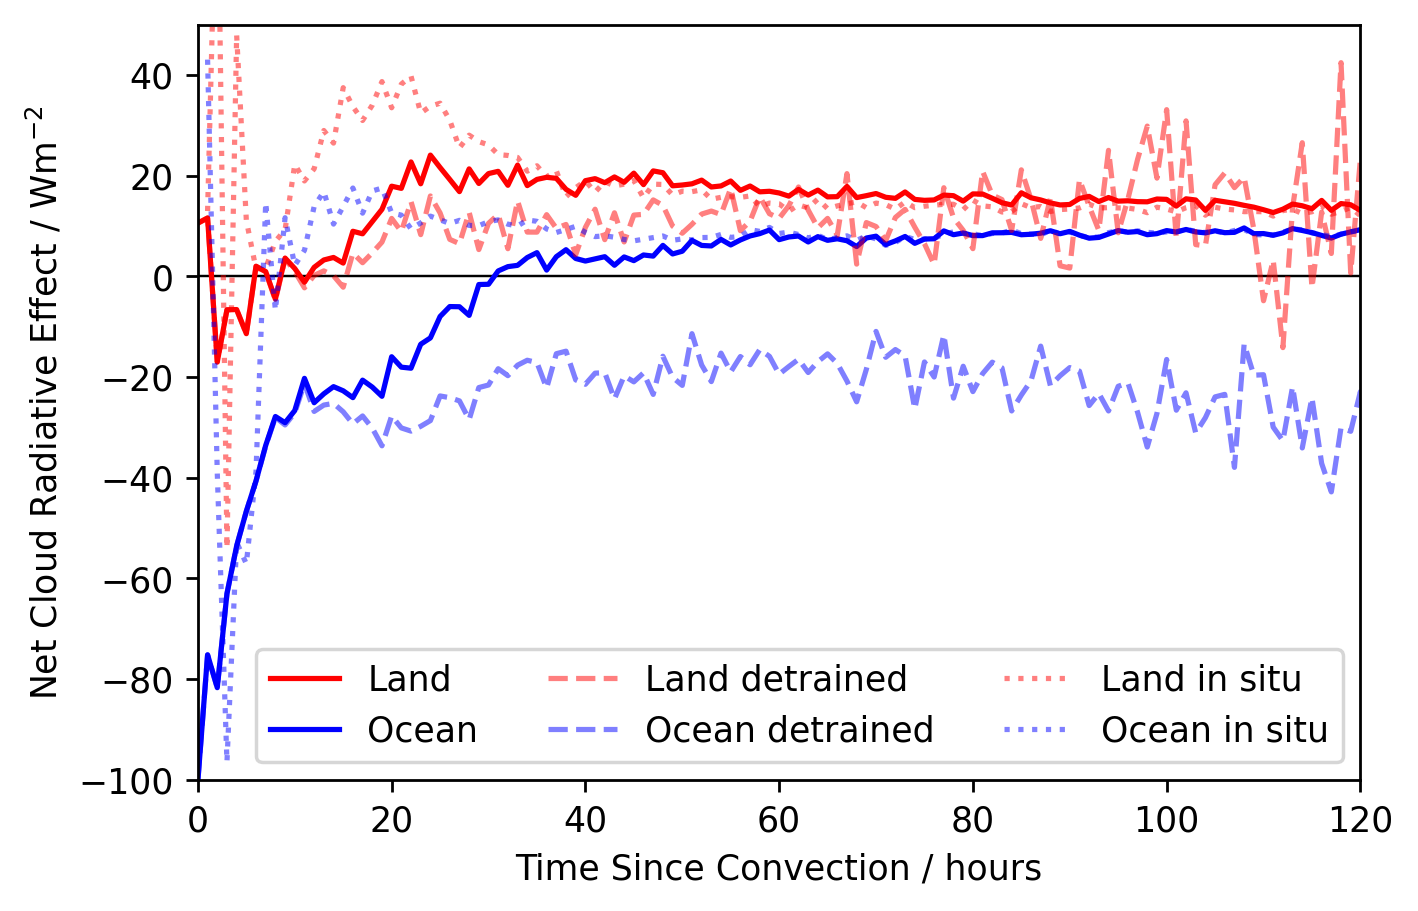

In [12]:
plt.figure(dpi=250)
plt.axhline(0,color='k',linewidth=0.7)
plt.plot(LW_AVERAGE_all_l + SW_AVERAGE_all_l, label='Land',color='red')
plt.plot(LW_AVERAGE_all_o + SW_AVERAGE_all_o, label='Ocean',color='blue')

plt.plot(LW_AVERAGE_det_l + SW_AVERAGE_det_l, label='Land detrained',color='red',linestyle='dashed',alpha=0.5)
plt.plot(LW_AVERAGE_det_o + SW_AVERAGE_det_o, label='Ocean detrained',color='blue',linestyle='dashed',alpha=0.5)

plt.plot(LW_AVERAGE_ins_l + SW_AVERAGE_ins_l, label='Land in situ',color='red',linestyle='dotted',alpha=0.5)
plt.plot(LW_AVERAGE_ins_o + SW_AVERAGE_ins_o, label='Ocean in situ',color='blue',linestyle='dotted',alpha=0.5)
plt.xlim(0,120)

plt.ylim(-100,50)
plt.legend(ncol=3)
plt.xlabel('Time Since Convection / hours')
plt.ylabel('Net Cloud Radiative Effect / Wm$^{-2}$')


(-250.0, 181.38291138712896)

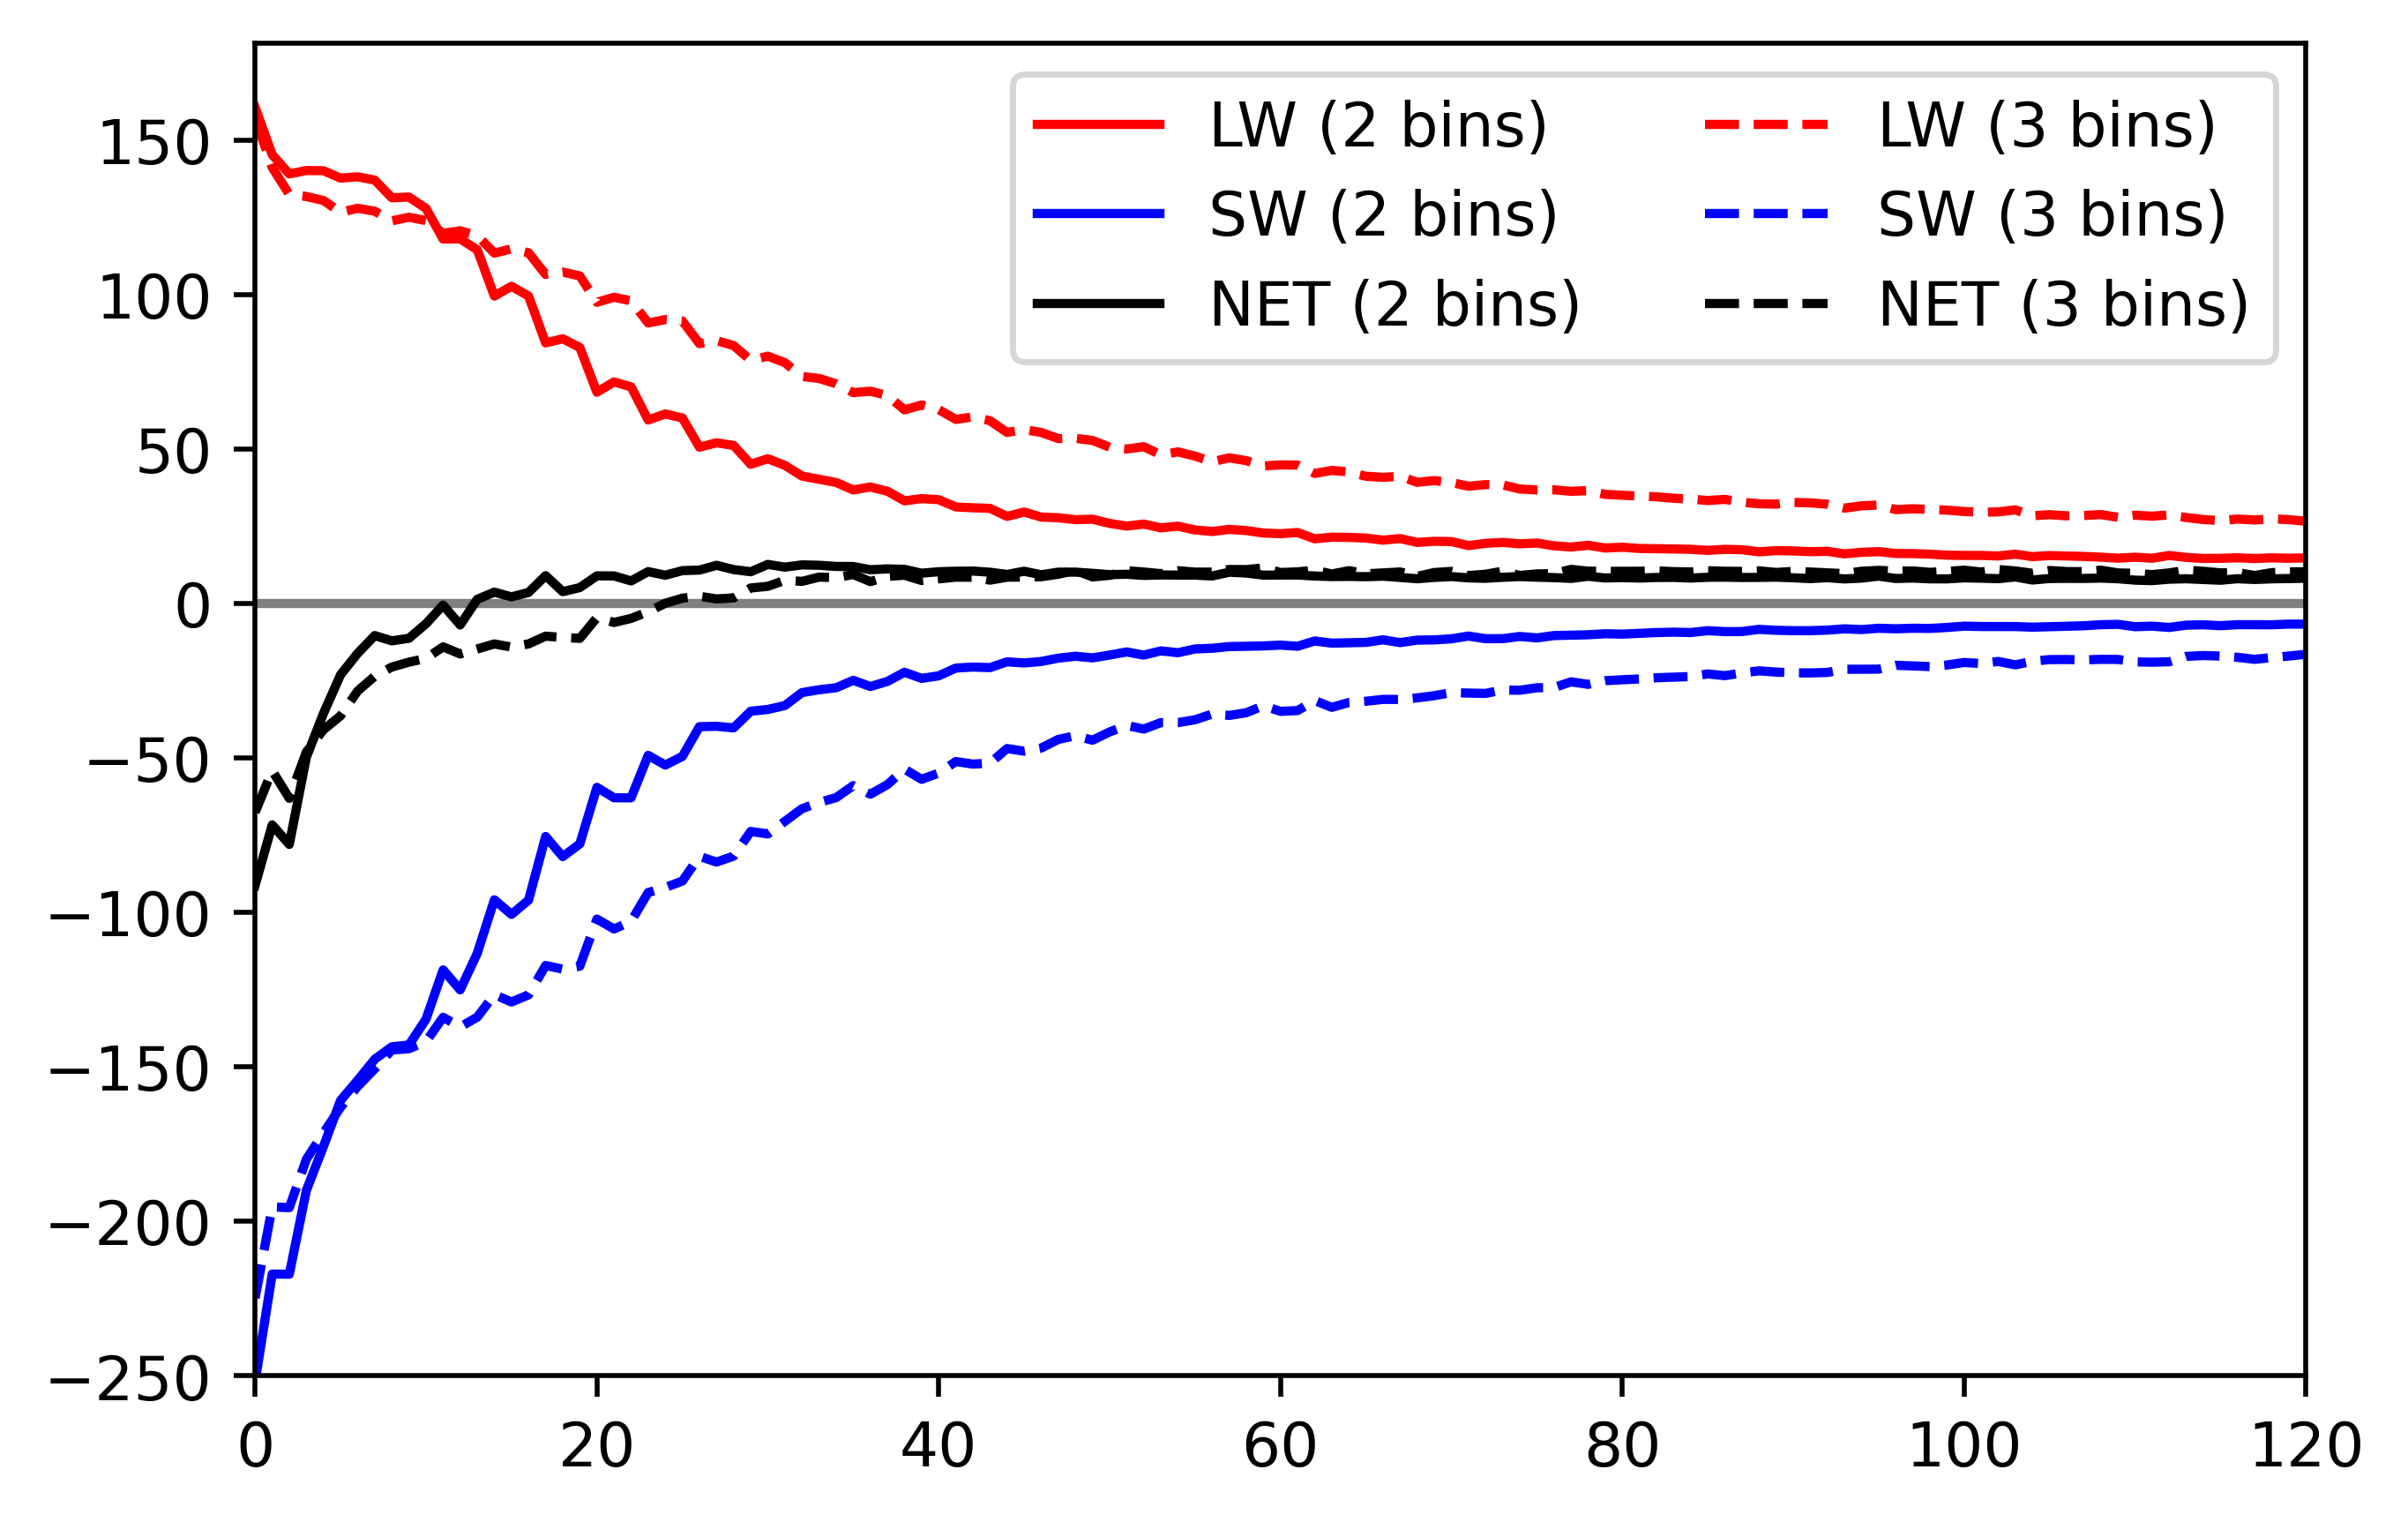

In [14]:
plt.figure(dpi=500)
plt.plot(LW_AVERAGE_all,color='red',label='LW (2 bins)')
plt.plot(SW_AVERAGE_all,color='blue',label='SW (2 bins)')
plt.plot(LW_AVERAGE_all+SW_AVERAGE_all,color='k',label='NET (2 bins)')

plt.plot(LW_AVERAGE_all_3,color='red',label='LW (3 bins)',linestyle='--')
plt.plot(SW_AVERAGE_all_3,color='blue',label='SW (3 bins)',linestyle='--')
plt.plot(LW_AVERAGE_all_3+SW_AVERAGE_all_3,color='k',label='NET (3 bins)',linestyle='--')

#plt.plot(LW_AVERAGE_det,color='red',linestyle='--',label='LW DET')
#plt.plot(SW_AVERAGE_det,color='blue',linestyle='--',label='SW DET')
#plt.plot(LW_AVERAGE_det+SW_AVERAGE_det,color='k',linestyle='--',label='NET DET')


##plt.plot(LW_AVERAGE_ins,color='red',linestyle=':',label='LW INS')
#plt.plot(SW_AVERAGE_ins,color='blue',linestyle=':',label='SW INS')
#plt.plot(LW_AVERAGE_ins+SW_AVERAGE_ins,color='k',linestyle=':',label='NET INS')

plt.xlim(0,120)
plt.axhline(0,alpha=0.5,color='k')
plt.legend(ncol=2)
plt.ylim(-250)

In [ ]:
xlw = np.arange(0,200,1)
ylw = np.arange(0,200,1)

xsw = np.arange(0,200,1)
ysw = np.arange(0,200,1)

xnet = np.arange(-100,100,1)
ynet = np.arange(-100,100,1)

dettsc = np.where(detinsit>0,tsc,np.nan)

tscnan = np.where(tsc.astype(int)<0,False,tsc.astype(int))
tscnanv2 = np.where(tscnan>498,False,tscnan)

lwnan = np.where(np.isnan(tsc),np.nan,LW_AVERAGE_all[tscnanv2])
lwnanv2 = np.where(tsc>498,np.nan,lwnan)

swnan = np.where(np.isnan(tsc),np.nan,SW_AVERAGE_all[tscnanv2])
swnanv2 = np.where(tsc>498,np.nan,swnan)

tscsw =np.where(np.isnan(swcldy_fg[:]),np.nan,swnanv2[3*offset::3])
tsclw = np.where(np.isnan(lwcldy_f[:]),np.nan,lwnanv2[3*offset::3])
tscnet = np.where(np.isnan(lwcldy_f[:]),np.nan,lwnanv2[3*offset::3]) + np.where(np.isnan(swcldy_fg[:]),np.nan,swnanv2[3*offset::3])


tscsw_mean = np.nanmean(np.where(np.isnan(swcldy_fg[:]),np.nan,swnanv2[3*offset::3]),axis=0)
tsclw_mean = np.nanmean(np.where(np.isnan(lwcldy_f[:]),np.nan,lwnanv2[3*offset::3]),axis=0)
tscnet_mean = np.nanmean((np.where(np.isnan(lwcldy_f[:]),np.nan,lwnanv2[3*offset::3]) + np.where(np.isnan(swcldy_fg[:]),np.nan,swnanv2[3*offset::3])),axis=0)

cereslw_mean = np.nanmean(-lwcldy_f[:],axis=0)
ceressw_mean = np.nanmean(-swcldy_fg[:],axis=0)
ceresnet_mean = np.nanmean((-lwcldy_f[:] - swcldy_fg[:]),axis=0)

netcldy_f = -lwcldy_f[:] - swcldy_f[:]
tscnet = lwnanv2[:] + swnanv2[:]

results_lw = stats.linregress(tsclw_mean[~np.isnan(tsclw_mean)],cereslw_mean[~np.isnan(cereslw_mean)])
results_sw = stats.linregress(-tscsw_mean[~np.isnan(tscsw_mean)],-ceressw_mean[~np.isnan(ceressw_mean)])
results_net = stats.linregress(tscnet_mean[~np.isnan(tscnet_mean)],ceresnet_mean[~np.isnan(ceresnet_mean)])

adjlw = (tsclw_mean*results_lw[0]) + (results_lw[1])
adjsw = (tscsw_mean*results_sw[0]) - (results_sw[1])
adjnet = adjsw + adjlw
adjnetv2 = (tscnet_mean*results_net[0]) + (results_net[1])

resultslwadj = stats.linregress(adjlw[~np.isnan(adjlw)],cereslw_mean[~np.isnan(cereslw_mean)])
resultsswadj = stats.linregress(-adjsw[~np.isnan(adjsw)],-ceressw_mean[~np.isnan(ceressw_mean)])
resultsnetadj = stats.linregress(adjnet[~np.isnan(adjnet)],ceresnet_mean[~np.isnan(ceresnet_mean)])

ypredlw = results_lw[0]*xlw + results_lw[1]
ypredsw = results_sw[0]*xsw + results_sw[1]
yprednet = results_net[0]*xnet + results_net[1]

ypredlwadj = resultslwadj[0]*xlw + resultslwadj[1]
ypredswadj = resultsswadj[0]*xsw - resultsswadj[1]
yprednetadj = resultsnetadj[0]*xnet + resultsnetadj[1]

adjlw_h = (tsclw*results_lw[0]) + (results_lw[1])
adjsw_h = (tscsw*results_sw[0]) - (results_sw[1])
adjnet_h = adjsw_h + adjlw_h

In [ ]:
H_sw_o_all_adj, xedges, yedges_sw = np.histogram2d(tsc_t.flatten(),np.asarray(-adjsw_h[0:len(tsc_d)]).flatten(), bins=(xedges,yedges_sw))
H_lw_o_all_adj, xedges, yedges_lw = np.histogram2d(tsc_t.flatten(),np.asarray(-adjlw_h[0:len(tsc_d)]).flatten(), bins=(xedges,yedges_lw))

H_norm_lw_all_adj = np.zeros((499,499))
H_norm_sw_all_adj = np.zeros((499,999))
for i in range(499):

    H_norm_sw_all_adj[i] = H_sw_o_all_adj[i] / np.sum(H_sw_o_all_adj[i])
    H_norm_lw_all_adj[i] = H_lw_o_all_adj[i] / np.sum(H_lw_o_all_adj[i])

LW_AVERAGE_all_adj = np.zeros((499))
SW_AVERAGE_all_adj = np.zeros((499))
for i in range(499):

    LW_AVERAGE_all_adj[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_all_adj[i])
    SW_AVERAGE_all_adj[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_all_adj[i])

In [83]:
tsc_convolve = xr.open_mfdataset('/net/seldon/disk2/Users/gah20/TSCISCCP/TSC_CURRENT/*/*.nc',combine='nested',concat_dim='time')['TSC']
hist,bins = np.histogram(np.asarray(tsc_convolve[500:]).flatten(),bins=np.arange(0,501,1))
cumhist = np.cumsum(hist)
count = np.count_nonzero(np.isfinite(tsc_convolve[500:]))

cirrus = xr.open_mfdataset('/net/seldon/disk2/Users/gah20/TSCISCCP/TSC_CURRENT/*/*',combine='nested',concat_dim='time')['ConvCir']
detrainedtsc = np.where(cirrus>0,tsc_convolve,np.nan)
insitutsc = np.where(cirrus<0,tsc_convolve,np.nan)

In [84]:
tscnans = np.where(np.isnan(np.asarray(tsc_convolve).flatten()),500,np.asarray(tsc_convolve).flatten())
tscnans_det = np.where(np.isnan(np.asarray(detrainedtsc).flatten()),500,np.asarray(detrainedtsc).flatten())
tscnan_ins = np.where(np.isnan(np.asarray(insitutsc).flatten()),500,np.asarray(insitutsc).flatten())

counts = np.histogram(np.asarray(tscnans).flatten(),bins=np.arange(0,500,1))[0]
counts_det = np.histogram(np.asarray(tscnans_det).flatten(),bins=np.arange(0,500,1))[0]
counts_ins = np.histogram(np.asarray(tscnan_ins).flatten(),bins=np.arange(0,500,1))[0]

In [350]:
fit = np.polyval(np.polyfit(np.arange(0,120,1),ydata[0:120],120),np.arange(0,120,1))

/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/numpy/lib/polynomial.py:627: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3427: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [365]:
NET_AVERAGE = LW_AVERAGE_all + SW_AVERAGE_all
WEIGHTEDLWAVG = LW_AVERAGE_det*(counts_det/counts) + SW_AVERAGE_det*(counts_ins/counts)
WEIGHTEDSWAVG = SW_AVERAGE_ins*(counts_det/counts) + SW_AVERAGE_ins*(counts_ins/counts)

In [360]:
total_forcing = np.nansum(NET_AVERAGE * countsbinhist / np.nansum(countsbinhist))
total_forcing_weighted = np.nansum(WEIGHTEDNETAVG * countsbinhist / np.nansum(countsbinhist))

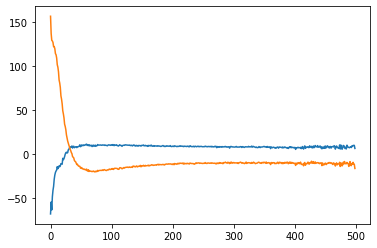

In [366]:
plt.plot(NET_AVERAGE)
plt.plot(WEIGHTEDNETAVG)

/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/numpy/lib/polynomial.py:627: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3427: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


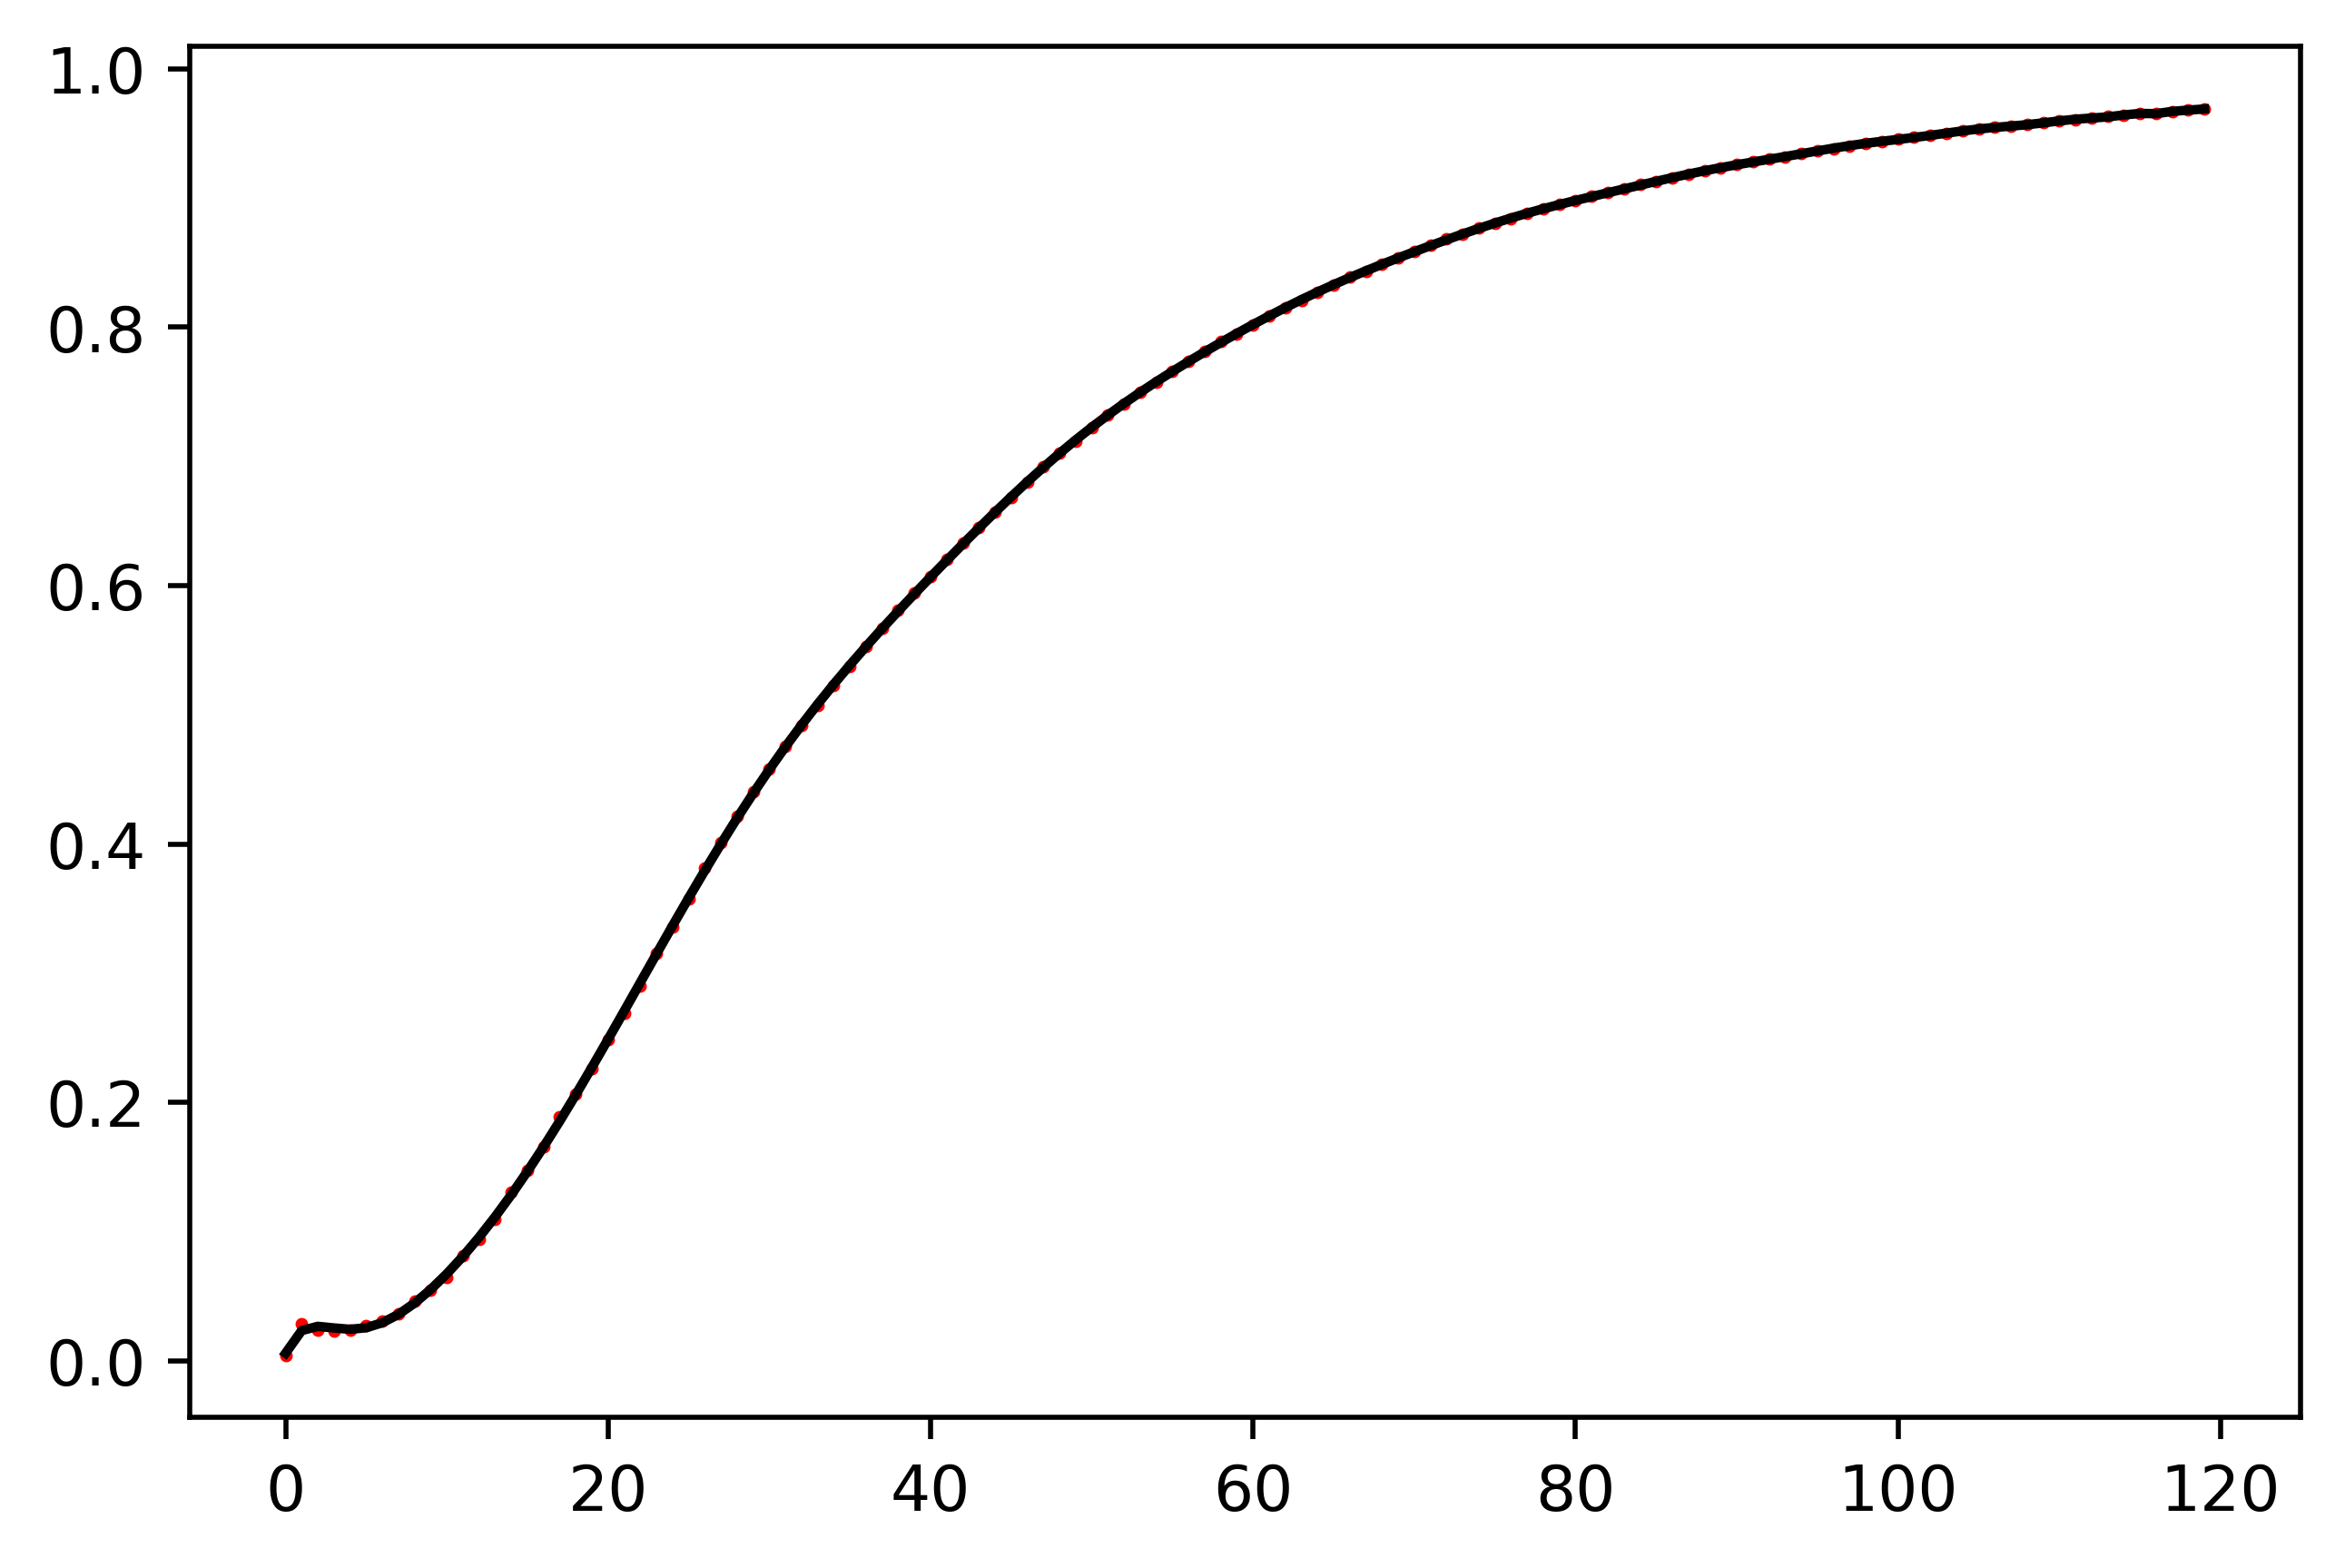

In [348]:
plt.figure(dpi=500)
plt.scatter(np.arange(0,120,1),ydata[0:120],label='data',s=1,color='red')
plt.plot(np.polyval(np.polyfit(np.arange(0,120,1),ydata[0:120],120),np.arange(0,120,1)),color='k',label='10th order polynomial')

array([0.00623583, 0.04259502, 0.03541021, 0.03404383, 0.03597876,
       0.04083062, 0.04650055, 0.05434642, 0.06895341, 0.08173009,
       0.09716388, 0.12160376, 0.14071236, 0.16436594, 0.19567917,
       0.22152509, 0.24854042, 0.28283126, 0.309708  , 0.33962407,
       0.37332234, 0.403196  , 0.43495076, 0.47296729, 0.50334972,
       0.53634939, 0.57165994, 0.60167119, 0.63183275, 0.66100492,
       0.68685502, 0.71328468, 0.73748992, 0.76068997, 0.7836286 ,
       0.80586531, 0.82903836, 0.85020464, 0.87107726, 0.89155313,
       0.91054906, 0.93011937, 0.94916595, 0.96709493, 0.9857103 ,
       1.00197605, 1.01968949, 1.03851371, 1.05375205, 1.06804612,
       1.08372599, 1.09794627, 1.11115591, 1.12485975, 1.13623839,
       1.1489032 , 1.16048618, 1.17211454, 1.18402613, 1.19247413,
       1.20250687, 1.21304125, 1.22302034, 1.23138169, 1.2409384 ,
       1.24905248, 1.2581875 , 1.26491256, 1.2728684 , 1.28077129,
       1.28821658, 1.29542409, 1.30226205, 1.30819897, 1.31494

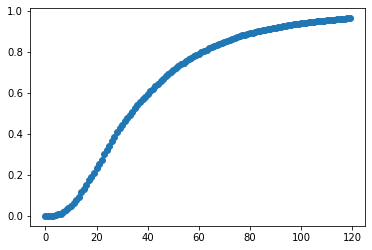

In [109]:
plt.scatter(np.arange(0,120,1),ydata[0:120])

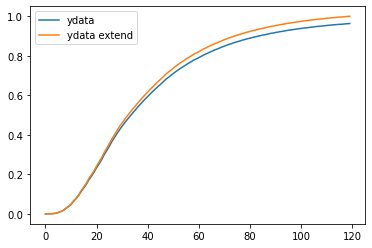

In [236]:
plt.plot(ydata,label='ydata')
plt.plot((ydata*0.6)/np.nanmax(ydata*0.6),label='ydata extend')
plt.legend()

In [309]:
ydata = 1 - counts_det[:499]/counts[:499]
xdata = np.arange(0,499,1)
from scipy.optimize import curve_fit

def sigmoid(x, L ,x0, k, b,g):
    y = L / ((1 + np.exp(-k*(x-x0)))**g) + b
    return (y)

p0 = [max(ydata), 23,1,min(ydata),1] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')

/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  


RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [311]:
def sigmoid(x, L ,x0, k, b,g):
    y = L / ((1 + np.exp(-k*(x-x0)))**g) + b
    return (y)

f = sigmoid(max(ydata),23,1,min(ydata),1,1)

In [314]:
f

12.499997829495825

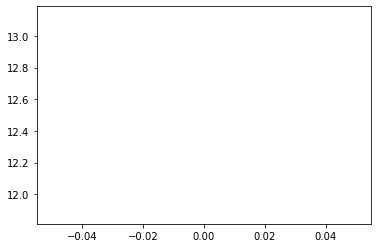

In [313]:
#plt.plot(np.arange(0,499,1)*1.5,counts_det/counts)
#plt.plot(counts_det/counts)
plt.plot(f)

In [ ]:
xloc = (np.arange(len(counts_det)))
newsize = int((len(counts_det)*1.2))
new_xloc = np.linspace(0, len(counts_det), newsize)
extcounts_det = np.interp(new_xloc, xloc, counts_det)
extcounts_ins = np.interp(new_xloc, xloc, counts_ins)
extcounts = np.interp(new_xloc, xloc, counts)

In [ ]:
H_sw_o_all_adj, xedges, yedges_sw = np.histogram2d(tsc_t.flatten(),np.asarray(-adjsw_h[0:len(tsc_d)]).flatten(), bins=(xedges,yedges_sw))
H_lw_o_all_adj, xedges, yedges_lw = np.histogram2d(tsc_t.flatten(),np.asarray(-adjlw_h[0:len(tsc_d)]).flatten(), bins=(xedges,yedges_lw))

H_norm_lw_all_adj = np.zeros((499,499))
H_norm_sw_all_adj = np.zeros((499,999))
for i in range(499):

    H_norm_sw_all_adj[i] = H_sw_o_all_adj[i] / np.sum(H_sw_o_all_adj[i])
    H_norm_lw_all_adj[i] = H_lw_o_all_adj[i] / np.sum(H_lw_o_all_adj[i])

LW_AVERAGE_all_adj = np.zeros((499))
SW_AVERAGE_all_adj = np.zeros((499))
for i in range(499):

    LW_AVERAGE_all_adj[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_all_adj[i])
    SW_AVERAGE_all_adj[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_all_adj[i])

In [ ]:
lifetimecre = np.zeros((500))
lifetimecre_det = np.zeros((500))
lifetimecre_ins = np.zeros((500))
for i in range(500):
    lifetimecre_det[i] = np.nansum(counts_det[0:i] * SW_AVERAGE_det[0:i])/np.nansum(counts_det[0:i]) + np.nansum(counts_det[0:i] * LW_AVERAGE_det[0:i])/np.nansum(counts_det[0:i])
    lifetimecre_ins[i] = np.nansum(counts_ins[0:i] * SW_AVERAGE_ins[0:i])/np.nansum(counts_ins[0:i]) + np.nansum(counts_ins[0:i] * LW_AVERAGE_ins[0:i])/np.nansum(counts_ins[0:i])
    lifetimecre[i] = np.nansum(counts[0:i] * weighted_all_sw[0:i])/np.nansum(counts[0:i]) + np.nansum(counts[0:i] * weighted_all_lw[0:i])/np.nansum(counts[0:i])

extlifetimecre = np.zeros((500))
extlifetimecre_det = np.zeros((500))
extlifetimecre_ins = np.zeros((500))
for i in range(500):
    extlifetimecre_det[i] = np.nansum(extcounts_det[0:i] * SW_AVERAGE_det[0:i])/np.nansum(extcounts_det[0:i]) + np.nansum(extcounts_det[0:i] * LW_AVERAGE_det[0:i])/np.nansum(extcounts_det[0:i])
    extlifetimecre_ins[i] = np.nansum(newinscounts[0:i] * SW_AVERAGE_ins[0:i])/np.nansum(newinscounts[0:i]) + np.nansum(newinscounts[0:i] * LW_AVERAGE_ins[0:i])/np.nansum(newinscounts[0:i])
    extlifetimecre[i] = np.nansum(extcounts[0:i] * weighted_all_sw_ext[0:i])/np.nansum(extcounts[0:i]) + np.nansum(extcounts[0:i] * weighted_all_lw_ext[0:i])/np.nansum(extcounts[0:i])


In [ ]:
plt.figure(dpi=500)


plt.plot(lifetimecre[0:],label='Cumulative CRE ('+str(np.round(lifetimecre[499],2)) +' Wm$^{-2}$)',color='k',linewidth=0.5)
plt.plot(extlifetimecre[0:],label='Cumulative CRE ('+str(np.round(extlifetimecre[499],2)) +' Wm$^{-2}$) - extended lifetime',color='k',linestyle='--',linewidth=0.5)
#plt.plot(lifetimecre_adj[1:],label='Adjusted Cumulative CRE ('+str(np.round(lifetimecre_adj[500],2))+' Wm$^{-2}$)')
plt.plot(lifetimecre_det[1:],label='Cumulative CRE ('+str(np.round(lifetimecre_det[499],2))+' Wm$^{-2}$) - Detrained',color='blue',linewidth=0.5)
plt.plot(lifetimecre_ins[1:],label='Cumulative CRE ('+str(np.round(lifetimecre_ins[499],2)) + ' Wm$^{-2}$) - Insitu',color='red',linewidth=0.5)
plt.plot(extlifetimecre_det[1:],label='Cumulative CRE ('+str(np.round(extlifetimecre_det[499],2))+' Wm$^{-2}$) - Detrained ext',color='blue',linestyle='--',linewidth=0.5)
plt.plot(extlifetimecre_ins[1:],label='Cumulative CRE ('+str(np.round(extlifetimecre_ins[499],2)) + ' Wm$^{-2}$) - Insitu ext',color='red',linestyle='--',linewidth=0.5)
plt.legend()
plt.xlabel('Time Since Convection / hours')
plt.ylabel('Cumulative CRE / Wm$^{-2}$')
plt.savefig('/disk1/Users/gah20/CRE_Study/CumuluativeCRE_ext.png',dpi=500)